In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# NeurIPS 2025 Open Polymer Prediction: Baseline Pipeline

This notebook runs the full baseline pipeline for the competition, including:
- Data preparation (LMDB creation)
- Model training and validation
- Test prediction and submission generation


In [2]:
# !pip install torch_geometric
# !pip install rdkit 
# !pip install ogb
# !pip install lmdb
# !pip install lz4

In [3]:
import os
import sys
import sys
sys.path.append('/kaggle/input/polymer')
import random
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from dataset_polymer_fixed import LMDBDataset
from polymer_model import PolymerPredictor
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## 2. Check/Create LMDBs (train & test)
If LMDBs are missing, run the builder scripts. Comment out after first run.


In [4]:
# Paths - Fixed for Kaggle environment
if os.path.exists('/kaggle'):
    DATA_ROOT = '/kaggle/input/neurips-open-polymer-prediction-2025'
    CHUNK_DIR = '/kaggle/working/processed_chunks'  # Writable directory
    BACKBONE_PATH = '/kaggle/input/polymer/best_gnn_transformer_hybrid.pt'
else:
    DATA_ROOT = 'data'
    CHUNK_DIR = os.path.join(DATA_ROOT, 'processed_chunks')
    BACKBONE_PATH = 'best_gnn_transformer_hybrid.pt'

TRAIN_LMDB = os.path.join(CHUNK_DIR, 'polymer_train3d_dist.lmdb')
TEST_LMDB = os.path.join(CHUNK_DIR, 'polymer_test3d_dist.lmdb')

print(f"Data root: {DATA_ROOT}")
print(f"LMDB directory: {CHUNK_DIR}")
print(f"Train LMDB: {TRAIN_LMDB}")
print(f"Test LMDB: {TEST_LMDB}")

# Create LMDBs if they don't exist
if not os.path.exists(TRAIN_LMDB) or not os.path.exists(TEST_LMDB):
    print('Building LMDBs...')
    os.makedirs(CHUNK_DIR, exist_ok=True)
    # Run the LMDB builders
    !python build_polymer_lmdb_fixed.py train
    !python build_polymer_lmdb_fixed.py test
    print('LMDB creation complete.')
else:
    print('LMDBs already exist.')


Data root: data
LMDB directory: data\processed_chunks
Train LMDB: data\processed_chunks\polymer_train3d_dist.lmdb
Test LMDB: data\processed_chunks\polymer_test3d_dist.lmdb
LMDBs already exist.


In [ ]:
# Initialize model with correct backbone path
model = PolymerPredictor(
    backbone_ckpt=BACKBONE_PATH,
    n_out=5,
    freeze=True,  # Keep backbone frozen initially
    use_gap=True  # Don't use HOMO-LUMO gap head
).to(device)

model.backbone.eval()

print('Model initialized with frozen backbone')
print(f'Total parameters: {sum(p.numel() for p in model.parameters()):,}')
print(f'Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')


In [ ]:
# Training helper functions
def weighted_mae_loss(pred, target, mask):
    """Compute weighted MAE loss for polymer properties"""
    valid_pred = pred[mask]
    valid_target = target[mask]
    
    if len(valid_pred) == 0:
        return torch.tensor(0.0, device=pred.device, requires_grad=True)
    
    return F.l1_loss(valid_pred, valid_target)

def compute_metrics(pred, target, mask):
    """Compute validation metrics"""
    label_cols = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']
    results = {}
    
    for i, col in enumerate(label_cols):
        col_mask = mask[:, i]
        if col_mask.sum() > 0:
            col_mae = F.l1_loss(pred[col_mask, i], target[col_mask, i]).item()
            results[f'{col}_MAE'] = col_mae
        else:
            results[f'{col}_MAE'] = float('nan')
    
    # Overall MAE
    if mask.sum() > 0:
        overall_mae = F.l1_loss(pred[mask], target[mask]).item()
        results['Overall_MAE'] = overall_mae
    else:
        results['Overall_MAE'] = float('nan')
    
    return results

print("Training functions defined successfully!")


Training functions defined successfully!


## 3. Train/Validation Split
Create a stratified split based on label availability (how many non-NaN values each row has).


In [ ]:
# # 1. Create a new DataFrame with only the SMILES and Rg columns
# df_Rg = df[['SMILES', 'Rg']].copy()

# print("Initial Rg DataFrame shape:", df_Rg.shape)
# print("Initial Rg Missing Values:")
# print(df_Rg.isnull().sum())

# # 2. Drop all rows where the 'Rg' value is missing
# df_Rg.dropna(subset=['Rg'], inplace=True)

# print("\nCleaned Rg DataFrame shape:", df_Rg.shape)
# print("Cleaned Rg Missing Values:")
# print(df_Rg.isnull().sum())

In [ ]:
# Load train CSV and create split
train_csv = pd.read_csv(os.path.join(DATA_ROOT, 'train.csv'))
label_cols = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']
# label_cols = ['Tg']
ids = train_csv['id'].values

# Stratify by number of non-NaN labels per row
stratify_col = train_csv[label_cols].notna().sum(axis=1)
train_ids, val_ids = train_test_split(
    ids, 
    test_size=0.1,  # 10% validation
    random_state=42,
    stratify=stratify_col
)

print(f'Train/val split: {len(train_ids)} / {len(val_ids)} samples')

# Show label availability stats for both splits
def print_split_stats(split_ids, name):
    split_df = train_csv[train_csv['id'].isin(split_ids)]
    avail = split_df[label_cols].notna().sum()
    print(f'\n{name} set label counts:')
    for col, count in avail.items():
        print(f'{col:>8}: {count:>4} ({count/len(split_ids):>6.1%})')

print_split_stats(train_ids, 'Train')
print_split_stats(val_ids, 'Val')


Train/val split: 7175 / 798 samples

Train set label counts:
      Tg:  456 (  6.4%)
     FFV: 6336 ( 88.3%)
      Tc:  660 (  9.2%)
 Density:  550 (  7.7%)
      Rg:  551 (  7.7%)

Val set label counts:
      Tg:   55 (  6.9%)
     FFV:  694 ( 87.0%)
      Tc:   77 (  9.6%)
 Density:   63 (  7.9%)
      Rg:   63 (  7.9%)


## 4. Data Loading
Create DataLoaders using the fast LMDB datasets for both train and validation sets.


In [ ]:
# DataLoader parameters
BATCH_SIZE = 64
NUM_WORKERS = 4  # Adjust based on your CPU

# Create train and validation loaders
train_loader = DataLoader(
    LMDBDataset(train_ids, TRAIN_LMDB),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

val_loader = DataLoader(
    LMDBDataset(val_ids, TRAIN_LMDB),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

print(f'Created DataLoaders with {BATCH_SIZE} batch size')
print(f'Train: {len(train_loader)} batches')
print(f'Val: {len(val_loader)} batches')


Created DataLoaders with 64 batch size
Train: 113 batches
Val: 13 batches


## 5. Weighted MAE (wMAE) Utility
Implement the competition's weighted MAE metric. We approximate test ranges using the train set since true test ranges are hidden.


In [ ]:
# ---- Canonical weighted MAE (factory + closure) ----
import numpy as np
import torch

LABEL_COLS = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']  # single source of truth

def make_wmae_fn(train_df, label_cols=LABEL_COLS, eps=1e-6):
    """
    Precompute n_t and delta_t from the *train* split and
    return a closure compute_wmae(pred, true, mask=None).
    """
    train_labels = train_df[label_cols].values.astype(np.float64)

    # counts ignoring NaN
    n_t = np.sum(~np.isnan(train_labels), axis=0).astype(np.float64)

    # robust range via percentiles; fallback to max-min; final floor
    p1  = np.nanpercentile(train_labels, 1,  axis=0)
    p99 = np.nanpercentile(train_labels, 99, axis=0)
    delta_t = p99 - p1
    fallback = (np.nanmax(train_labels, axis=0) - np.nanmin(train_labels, axis=0))
    delta_t = np.where((~np.isfinite(delta_t)) | (delta_t <= 0), fallback, delta_t)
    delta_t = np.where((~np.isfinite(delta_t)) | (delta_t <= 0), 1.0, delta_t).astype(np.float64)

    def compute_wmae(pred, true, mask=None):
        """
        Robust weighted MAE w/ protections against NaN/Inf.
        Returns: wmae (float), mae_per_task (5,), weights (5,)
        """
        # to numpy
        if isinstance(pred, torch.Tensor): pred = pred.detach().cpu().numpy()
        if isinstance(true, torch.Tensor): true = true.detach().cpu().numpy()
        if mask is None:
            mask = ~np.isnan(true)
        elif isinstance(mask, torch.Tensor):
            mask = mask.detach().cpu().numpy().astype(bool)
        else:
            mask = mask.astype(bool)

        pred = pred.astype(np.float64)
        true = true.astype(np.float64)

        # abs error with mask
        abs_err = np.abs(pred - true)
        abs_err[~mask] = 0.0

        # per-task counts present in this eval split
        counts_val = mask.sum(axis=0)

        # MAE per task (safe divide)
        mae_per_task = abs_err.sum(axis=0) / np.maximum(counts_val, 1)

        # sanitize precomputed arrays
        n_t_s = np.where((~np.isfinite(n_t)) | (n_t <= 0), 0.0, n_t)
        delta_t_s = np.where((~np.isfinite(delta_t)) | (delta_t <= 0), eps, delta_t)

        # raw weights (1/sqrt(n_t * delta_t)) for tasks with train labels
        weight_raw = np.zeros_like(mae_per_task, dtype=np.float64)
        valid_train = (n_t_s > 0)
        weight_raw[valid_train] = 1.0 / np.sqrt(n_t_s[valid_train] * delta_t_s[valid_train])

        # drop tasks not present in this val split
        present_val = (counts_val > 0)
        weight_raw[~present_val] = 0.0

        denom = weight_raw.sum()
        if denom <= 0 or not np.isfinite(denom):
            # fallback: equal weights over tasks present in val
            weights = np.zeros_like(weight_raw)
            m = present_val.sum()
            if m > 0:
                weights[present_val] = 1.0 / m
        else:
            weights = weight_raw / denom

        wmae = float((mae_per_task * weights).sum())
        return wmae, mae_per_task.astype(np.float64), weights.astype(np.float64)

    # small log so you can see what the fixed weights would be on a dummy
    print('Label statistics from train set:')
    print('\nSample counts (n_t):')
    for col, count in zip(label_cols, n_t):
        print(f'{col:>8}: {int(count):>6}')
    print('\nValue ranges (delta_t):')
    for col, delta in zip(label_cols, delta_t):
        print(f'{col:>8}: {delta:>8.3f}')

    # example weights (for visibility)
    dummy = np.zeros((1, len(label_cols)), dtype=np.float64)
    _, _, weights = compute_wmae(dummy, dummy, np.ones_like(dummy, dtype=bool))
    print('\nResulting (normalized) weights to be used at eval time:')
    for col, w in zip(label_cols, weights):
        print(f'{col:>8}: {w:>8.3f}')

    return compute_wmae

# Build the single canonical function bound to train statistics
wmae_fn = make_wmae_fn(train_csv, LABEL_COLS)

# (Optional) Shadow any older definitions to avoid accidental use
compute_wmae = wmae_fn

Label statistics from train set:

Sample counts (n_t):
      Tg:    511
     FFV:   7030
      Tc:    737
 Density:    613
      Rg:    614

Value ranges (delta_t):
      Tg:  513.394
     FFV:    0.145
      Tc:    0.366
 Density:    0.743
      Rg:   18.170

Resulting (normalized) weights to be used at eval time:
      Tg:    0.013
     FFV:    0.208
      Tc:    0.405
 Density:    0.311
      Rg:    0.063


## 6. Model Setup
Initialize the PolymerPredictor with frozen backbone weights and configure training.


In [ ]:
# Model initialization
model = PolymerPredictor(
    backbone_ckpt='best_gnn_transformer_hybrid.pt',
    freeze=True,  # Freeze backbone weights
    use_gap=True  # Don't use gap feature initially
).to(device)

model.backbone.eval()

# Optimizer (only train the head)
optimizer = torch.optim.AdamW(
    model.head.parameters(),
    lr=1e-4,
    weight_decay=1e-5
)

# Training config
EPOCHS = 100
EARLY_STOP_PATIENCE = 20  # Stop if no improvement for this many epochs

print(f'Model initialized on {device}')
print('Trainable parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))


Model initialized on cuda
Trainable parameters: 265221


c:\Users\mattg\Downloads\kaggle_polymers_competition\polymer_model.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(backbone_ckpt, map_location='cpu'))


In [ ]:
import sys, numpy as np, torch
print("Python:", sys.version.split()[0])
print("NumPy:", np.__version__)
print("Torch:", torch.__version__)

try:
    import torch_scatter
    print("torch_scatter:", getattr(torch_scatter, "__version__", "import ok"))
except Exception as e:
    print("torch_scatter import failed:", e)

Python: 3.8.20
NumPy: 1.24.3
Torch: 2.4.1+cu118
torch_scatter: 2.1.2+pt24cu118


## 7. Training Loop
Train for ~30 epochs with early stopping based on validation wMAE.


In [ ]:
# Training loop with early stopping
best_val_wmae = float('inf')
patience_counter = 0
train_losses = []
val_wmaes = []

for epoch in range(EPOCHS):
    # Training
    model.train()
    train_loss = 0
    
    for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS} - Training'):
        batch = batch.to(device)
        pred = model(batch)
        
        # Compute loss only on non-NaN labels
        mask = ~torch.isnan(batch.y)
        loss = torch.abs(pred - batch.y)[mask].mean()  # MAE loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * batch.num_graphs
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_preds, val_trues, val_masks = [], [], []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validation'):
            batch = batch.to(device)
            pred = model(batch)
            val_preds.append(pred.cpu())
            val_trues.append(batch.y.cpu())
            val_masks.append(~torch.isnan(batch.y.cpu()))
    
    val_preds = torch.cat(val_preds, dim=0)
    val_trues = torch.cat(val_trues, dim=0)
    val_masks = torch.cat(val_masks, dim=0)
    
    # Compute validation wMAE
    val_wmae, val_maes, w = wmae_fn(val_preds, val_trues, val_masks)

    if not np.isfinite(val_wmae):
        print("Warning: non-finite val_wmae; setting to +inf for early stopping.")
        val_wmae = float('inf')
      
    val_wmaes.append(val_wmae)
    
    # Print epoch stats
    print(f'\nEpoch {epoch+1}/{EPOCHS}:')
    print(f'Train loss: {train_loss:.4f}')
    print(f'Val wMAE: {val_wmae:.4f}')
    print('Val MAEs:', ' '.join(f'{mae:.4f}' for mae in val_maes))
    
    # Early stopping
    if val_wmae < best_val_wmae:
        best_val_wmae = val_wmae
        patience_counter = 0
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_wmae': val_wmae,
        }, 'best_polymer_model.pt')
        print('Saved new best model!')
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOP_PATIENCE:
            print(f'\nEarly stopping after {epoch+1} epochs!')
            break

print(f'\nTraining complete! Best validation wMAE: {best_val_wmae:.4f}')

## 8. Plot Training History
Visualize the training loss and validation wMAE over epochs.


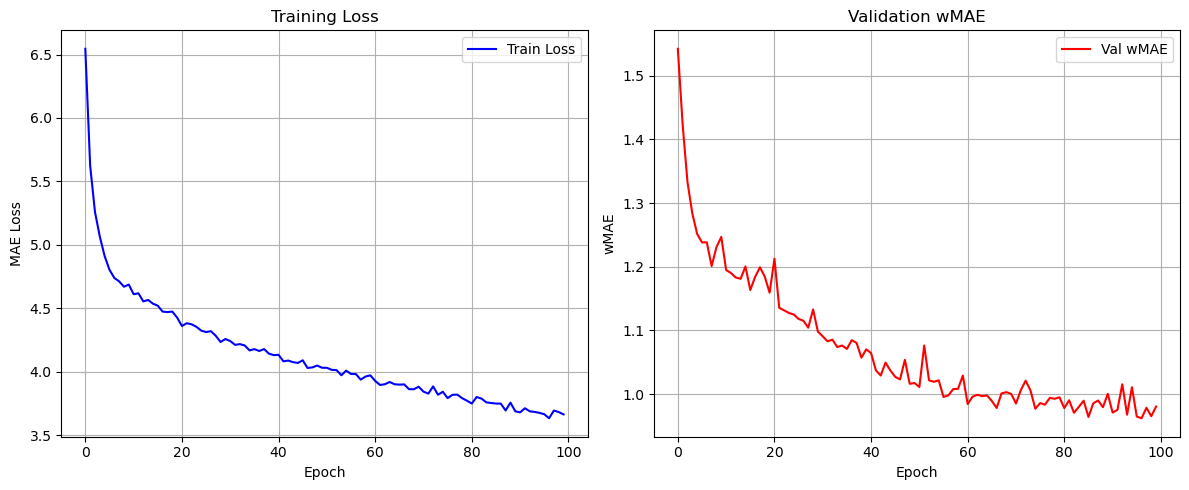

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()

# Plot validation wMAE
plt.subplot(1, 2, 2)
plt.plot(val_wmaes, 'r-', label='Val wMAE')
plt.xlabel('Epoch')
plt.ylabel('wMAE')
plt.title('Validation wMAE')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# Fine Tuning

In [ ]:
import torch
import re
from torch import nn
from math import pi

# -------- utils
def set_trainable(module: nn.Module, trainable: bool):
    for p in module.parameters():
        p.requires_grad = trainable

def freeze_batchnorm(module: nn.Module):
    """Keep BN in eval + frozen (common when unfreezing deep nets)."""
    for m in module.modules():
        if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
            m.eval()
            for p in m.parameters():
                p.requires_grad = False

def find_modules_by_name(model: nn.Module, name_patterns):
    """Return list of modules whose qualified name matches any regex in name_patterns."""
    if isinstance(name_patterns, str):
        name_patterns = [name_patterns]
    pats = [re.compile(p) for p in name_patterns]
    hits = []
    for qname, module in model.named_modules():
        if any(p.search(qname) for p in pats):
            hits.append((qname, module))
    # dedupe by module identity, keep order
    seen = set()
    uniq = []
    for q, m in hits:
        if id(m) not in seen:
            uniq.append((q, m))
            seen.add(id(m))
    return uniq

def backbone_module(model):
    for attr in ["backbone", "encoder", "gnn", "trunk"]:
        if hasattr(model, attr):
            return getattr(model, attr)
    # fallback to model itself
    return model

def head_module(model):
    for attr in ["head", "classifier", "regressor", "readout"]:
        if hasattr(model, attr):
            return getattr(model, attr)
    return None

def last_k_blocks(backbone: nn.Module, k: int = 2):
    """
    Try to extract the last K blocks from common containers like nn.Sequential or lists of layers.
    If not found, returns empty list.
    """
    # Common containers
    candidates = []
    for name in ["layers", "blocks", "stages", "encoder_layers"]:
        if hasattr(backbone, name):
            seq = getattr(backbone, name)
            try:
                # nn.Sequential, ModuleList, python list
                tail = list(seq)[-k:] if len(seq) >= k else list(seq)
                candidates = tail
            except Exception:
                pass
    # Fallback: take last K child modules
    if not candidates:
        kids = list(backbone.children())
        if kids:
            candidates = kids[-k:] if len(kids) >= k else kids
    return [m for m in candidates if isinstance(m, nn.Module)]

def param_groups_for(model: nn.Module, trainable_scopes, base_lr=1e-4, wd=1e-5):
    """
    Build optimizer groups with de-duplication across scopes.
    Earlier groups have priority over later ones.
    """
    seen = set()
    groups = []

    for module, lr_mult in trainable_scopes:
        params = []
        for p in module.parameters():
            if p.requires_grad and id(p) not in seen:
                params.append(p)
                seen.add(id(p))
        if params:  # skip empty buckets
            groups.append({"params": params, "lr": base_lr * lr_mult, "weight_decay": wd})

    # Catch-all (rare): any remaining trainable params not covered explicitly
    rest = [p for p in model.parameters() if p.requires_grad and id(p) not in seen]
    if rest:
        groups.append({"params": rest, "lr": base_lr * 0.1, "weight_decay": wd})

    # Optional: sanity print
    # print("Param groups:", [len(g["params"]) for g in groups])

    return groups


class CosineWithWarmup(torch.optim.lr_scheduler._LRScheduler):
    """
    Cosine decay with linear warmup, reset per phase.
    T_total = num_steps for the phase.
    """
    def __init__(self, optimizer, warmup_steps=100, total_steps=1000, last_epoch=-1):
        self.warmup_steps = max(1, warmup_steps)
        self.total_steps = max(self.warmup_steps + 1, total_steps)
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        step = self.last_epoch + 1
        lrs = []
        for base_lr, group in zip(self.base_lrs, self.optimizer.param_groups):
            if step <= self.warmup_steps:
                scale = step / float(self.warmup_steps)
            else:
                t = (step - self.warmup_steps) / float(self.total_steps - self.warmup_steps)
                scale = 0.5 * (1.0 + torch.cos(torch.tensor(pi * t))).item()
            lrs.append(base_lr * scale)
        return lrs

# -------- phase planner
def configure_phase(model, phase_idx, K_last=2):
    """
    Returns: list of (module, lr_multiplier), and a human-readable name
    Phase 1: head only (1.0x)
    Phase 2: "attention" modules (0.33x) + head (1.0x)  [backbone still frozen]
    Phase 3: last K backbone blocks (0.2x) + attention (0.33x) + head (1.0x)
    Phase 4: all trainable (0.1x) except BatchNorm stays frozen
    """
    bb = backbone_module(model)
    hd = head_module(model)

    # first freeze everything
    set_trainable(model, False)
    freeze_batchnorm(model)

    # try to find attention-like modules (transformer/GAT/etc.)
    attn_hits = find_modules_by_name(
        model,
        name_patterns=[r"\b(attn|attention|multihead|gat|gine|transformer)\b", r"self_attn", r"mhsa", r"encoder\.layers\.\d+\.self_attn"]
    )
    attn_modules = [m for _, m in attn_hits]

    scopes = []
    name = ""

    if phase_idx == 1:
        if hd is not None:
            set_trainable(hd, True)
            scopes = [(hd, 1.0)]
        name = "Phase 1: head only"

    elif phase_idx == 2:
        if hd is not None:
            set_trainable(hd, True)
            scopes.append((hd, 1.0))
        # unfreeze attention modules only
        if attn_modules:
            for m in attn_modules:
                set_trainable(m, True)
            scopes.append((nn.ModuleList(attn_modules), 1/3))
        name = "Phase 2: attention + head"

    elif phase_idx == 3:
        if hd is not None:
            set_trainable(hd, True)
            scopes.append((hd, 1.0))
        if attn_modules:
            for m in attn_modules:
                set_trainable(m, True)
            scopes.append((nn.ModuleList(attn_modules), 1/3))
        last_blocks = last_k_blocks(bb, k=K_last)
        if last_blocks:
            for m in last_blocks:
                set_trainable(m, True)
            scopes.append((nn.ModuleList(last_blocks), 1/5))
        name = f"Phase 3: last {K_last} backbone blocks + attention + head"

    elif phase_idx == 4:
        # all layers except BN
        set_trainable(model, True)
        freeze_batchnorm(model)  # re-freeze BN after enabling everything
        # Discriminative LRs: head > attention > backbone
        if hd is not None:
            scopes.append((hd, 1.0))
        if attn_modules:
            scopes.append((nn.ModuleList(attn_modules), 1/3))
        scopes.append((backbone_module(model), 1/10))
        name = "Phase 4: full model (BN frozen)"

    return scopes, name

def run_phase(
    model,
    train_loader,
    val_loader,
    compute_wmae_fn,   # your compute_wmae function
    device,
    base_lr=1e-4,
    weight_decay=1e-5,
    epochs=10,
    warmup_steps=200,
    max_grad_norm=0.2,
    early_patience=None,
    phase_idx=1
):
    scopes, phase_name = configure_phase(model, phase_idx=phase_idx, K_last=2)
    assert scopes, f"No trainable scopes resolved for {phase_name}. Check module/attr names."

    # Build optimizer param groups
    groups = param_groups_for(model, scopes, base_lr=base_lr, wd=weight_decay)
    optimizer = torch.optim.AdamW(groups)
    total_steps = max(1, epochs * len(train_loader))
    scheduler = CosineWithWarmup(optimizer, warmup_steps=min(warmup_steps, total_steps//4), total_steps=total_steps)

    print(f"\n=== {phase_name} ===")
    print("Trainable parameters:",
          sum(p.numel() for p in model.parameters() if p.requires_grad))

    best_val = float("inf")
    patience = 0

    global_step = 0
    for ep in range(1, epochs+1):
        model.train()
        train_loss = 0.0

        for batch in train_loader:
            batch = batch.to(device)
            pred  = model(batch)
            mask  = ~torch.isnan(batch.y)
            loss  = weighted_mae_loss(pred, batch.y, mask)  # uses your existing loss

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            scheduler.step()
            train_loss += loss.item() * batch.num_graphs
            global_step += 1

        # Validation
        model.eval()
        with torch.no_grad():
            vp, vt, vm = [], [], []
            for batch in val_loader:
                batch = batch.to(device)
                pred = model(batch)
                vp.append(pred.cpu()); vt.append(batch.y.cpu()); vm.append(~torch.isnan(batch.y.cpu()))
            vp = torch.cat(vp, 0); vt = torch.cat(vt, 0); vm = torch.cat(vm, 0)
            val_wmae, _, _ = compute_wmae_fn(vp.numpy(), vt.numpy(), vm.numpy())

        print(f"[{phase_name}] Epoch {ep}/{epochs} "
              f"train_loss={train_loss/len(train_loader.dataset):.5f}  val_wMAE={val_wmae:.5f}")

        improved = val_wmae < best_val - 1e-6
        if improved:
            best_val = val_wmae
            patience = 0
            torch.save({"model_state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                        "val_wmae": val_wmae,
                        "phase": phase_idx,
                        "epoch": ep}, f"best_phase{phase_idx}.pt")
        else:
            patience += 1
            if early_patience is not None and patience >= early_patience:
                print(f"Early stop {phase_name} at epoch {ep}. Best val_wMAE={best_val:.5f}")
                break

    return best_val

def run_all_phases(
    model,
    train_loader,
    val_loader,
    compute_wmae_fn,
    device,
    base_lr=1e-4,
    phase_epochs=10,
    patience_per_phase=5
):
    """
    Executes the 4-phase schedule you described.
    You can tweak base_lr or phase_epochs to taste.
    """
    # Phase LRs relative to your description:
    # P1 = 1.0 * base_lr; P2 = base_lr/3; P3 = base_lr/5; P4 = base_lr/10
    # We implement this via lr_multipliers in configure_phase() and pass base_lr here.

    bests = []
    for i in [1,2,3,4]:
        best_val = run_phase(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            compute_wmae_fn=compute_wmae_fn,
            device=device,
            base_lr=base_lr,            # head uses 1.0x; deeper layers use smaller multipliers
            weight_decay=1e-5,
            epochs=phase_epochs,
            warmup_steps=min(200, phase_epochs * max(1, len(train_loader)//4)),
            max_grad_norm=0.2,
            early_patience=patience_per_phase,
            phase_idx=i
        )
        bests.append(best_val)
    print("Phase bests:", bests)
    return bests


In [ ]:
# Example: X epochs per phase = 10; feel free to adjust
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

phase_bests = run_all_phases(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    compute_wmae_fn=wmae_fn,  # your existing function
    device=device,
    base_lr=1e-5,                  # your “initial” LR for the head
    phase_epochs=10,               # X
    patience_per_phase=5
)


=== Phase 1: head only ===
Trainable parameters: 265221
[Phase 1: head only] Epoch 1/10 train_loss=3.61540  val_wMAE=0.95592
[Phase 1: head only] Epoch 2/10 train_loss=3.58386  val_wMAE=0.95584
[Phase 1: head only] Epoch 3/10 train_loss=3.61219  val_wMAE=0.95459
[Phase 1: head only] Epoch 4/10 train_loss=3.59931  val_wMAE=0.95090
[Phase 1: head only] Epoch 5/10 train_loss=3.60448  val_wMAE=0.95242
[Phase 1: head only] Epoch 6/10 train_loss=3.59080  val_wMAE=0.95175
[Phase 1: head only] Epoch 7/10 train_loss=3.56705  val_wMAE=0.95221
[Phase 1: head only] Epoch 8/10 train_loss=3.59825  val_wMAE=0.95037
[Phase 1: head only] Epoch 9/10 train_loss=3.57837  val_wMAE=0.95088
[Phase 1: head only] Epoch 10/10 train_loss=3.56918  val_wMAE=0.95040

=== Phase 2: attention + head ===
Trainable parameters: 6571013
[Phase 2: attention + head] Epoch 1/10 train_loss=3.61628  val_wMAE=0.95178
[Phase 2: attention + head] Epoch 2/10 train_loss=3.58294  val_wMAE=0.95229
[Phase 2: attention + head] Epoch 3

=== Phase 1: head only ===
Trainable parameters: 265221
[Phase 1: head only] Epoch 1/10 train_loss=3.61540  val_wMAE=0.95592
[Phase 1: head only] Epoch 2/10 train_loss=3.58386  val_wMAE=0.95584
[Phase 1: head only] Epoch 3/10 train_loss=3.61219  val_wMAE=0.95459
[Phase 1: head only] Epoch 4/10 train_loss=3.59931  val_wMAE=0.95090
[Phase 1: head only] Epoch 5/10 train_loss=3.60448  val_wMAE=0.95242
[Phase 1: head only] Epoch 6/10 train_loss=3.59080  val_wMAE=0.95175
[Phase 1: head only] Epoch 7/10 train_loss=3.56705  val_wMAE=0.95221
[Phase 1: head only] Epoch 8/10 train_loss=3.59825  val_wMAE=0.95037
[Phase 1: head only] Epoch 9/10 train_loss=3.57837  val_wMAE=0.95088
[Phase 1: head only] Epoch 10/10 train_loss=3.56918  val_wMAE=0.95040

=== Phase 2: attention + head ===
Trainable parameters: 6571013
[Phase 2: attention + head] Epoch 1/10 train_loss=3.61628  val_wMAE=0.95178
[Phase 2: attention + head] Epoch 2/10 train_loss=3.58294  val_wMAE=0.95229
[Phase 2: attention + head] Epoch 3/10 train_loss=3.57748  val_wMAE=0.95284
[Phase 2: attention + head] Epoch 4/10 train_loss=3.58127  val_wMAE=0.95250
[Phase 2: attention + head] Epoch 5/10 train_loss=3.54855  val_wMAE=0.94494
[Phase 2: attention + head] Epoch 6/10 train_loss=3.54436  val_wMAE=0.94343
[Phase 2: attention + head] Epoch 7/10 train_loss=3.51442  val_wMAE=0.94670
[Phase 2: attention + head] Epoch 8/10 train_loss=3.49963  val_wMAE=0.94497
[Phase 2: attention + head] Epoch 9/10 train_loss=3.52985  val_wMAE=0.94403
[Phase 2: attention + head] Epoch 10/10 train_loss=3.52261  val_wMAE=0.94391

=== Phase 3: last 2 backbone blocks + attention + head ===
Trainable parameters: 6736902
[Phase 3: last 2 backbone blocks + attention + head] Epoch 1/10 train_loss=3.50199  val_wMAE=0.94596
[Phase 3: last 2 backbone blocks + attention + head] Epoch 2/10 train_loss=3.49476  val_wMAE=0.94061
[Phase 3: last 2 backbone blocks + attention + head] Epoch 3/10 train_loss=3.50136  val_wMAE=0.94145
[Phase 3: last 2 backbone blocks + attention + head] Epoch 4/10 train_loss=3.48556  val_wMAE=0.94337
[Phase 3: last 2 backbone blocks + attention + head] Epoch 5/10 train_loss=3.47009  val_wMAE=0.93935
[Phase 3: last 2 backbone blocks + attention + head] Epoch 6/10 train_loss=3.45512  val_wMAE=0.93938
[Phase 3: last 2 backbone blocks + attention + head] Epoch 7/10 train_loss=3.46956  val_wMAE=0.93898
[Phase 3: last 2 backbone blocks + attention + head] Epoch 8/10 train_loss=3.44134  val_wMAE=0.93802
[Phase 3: last 2 backbone blocks + attention + head] Epoch 9/10 train_loss=3.45068  val_wMAE=0.93893
[Phase 3: last 2 backbone blocks + attention + head] Epoch 10/10 train_loss=3.45236  val_wMAE=0.93874

=== Phase 4: full model (BN frozen) ===
Trainable parameters: 11054086
[Phase 4: full model (BN frozen)] Epoch 1/10 train_loss=3.40576  val_wMAE=0.94212
[Phase 4: full model (BN frozen)] Epoch 2/10 train_loss=3.40394  val_wMAE=0.94550
[Phase 4: full model (BN frozen)] Epoch 3/10 train_loss=3.41206  val_wMAE=0.94036
[Phase 4: full model (BN frozen)] Epoch 4/10 train_loss=3.41391  val_wMAE=0.93804
[Phase 4: full model (BN frozen)] Epoch 5/10 train_loss=3.37577  val_wMAE=0.93902
[Phase 4: full model (BN frozen)] Epoch 6/10 train_loss=3.33919  val_wMAE=0.93902
[Phase 4: full model (BN frozen)] Epoch 7/10 train_loss=3.34373  val_wMAE=0.94063
[Phase 4: full model (BN frozen)] Epoch 8/10 train_loss=3.30853  val_wMAE=0.93814
[Phase 4: full model (BN frozen)] Epoch 9/10 train_loss=3.29286  val_wMAE=0.93691
[Phase 4: full model (BN frozen)] Epoch 10/10 train_loss=3.29162  val_wMAE=0.93719
Phase bests: [0.9503693945007222, 0.9434330660877239, 0.9380207294015979, 0.9369071777301273]

## 9. Generate Submission
Load the best model, predict on test set, and create submission file.


In [ ]:
# Load best model
checkpoint = torch.load('best_finetuned_polymer_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model from epoch {checkpoint['epoch']+1} with val_wmae: {checkpoint['val_wmae']:.4f}")

# Load test data
test_csv = pd.read_csv(os.path.join(DATA_ROOT, 'test.csv'))
test_ids = test_csv['id'].values
test_loader = DataLoader(
    LMDBDataset(test_ids, TEST_LMDB),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

# Predict on test set
model.eval()
test_preds = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc='Predicting test set'):
        batch = batch.to(device)
        pred = model(batch)
        test_preds.append(pred.cpu().numpy())

test_preds = np.concatenate(test_preds, axis=0)

# Create submission DataFrame
submission = pd.DataFrame(test_preds, columns=label_cols)
submission.insert(0, 'id', test_ids)

# Save submission
submission.to_csv('submission.csv', index=False)
print('\nSubmission file created: submission.csv')
print('Shape:', submission.shape)
print('\nFirst few rows:')
print(submission.head())

Loaded model from epoch 13 with val_wmae: 0.9088


C:\Users\mattg\AppData\Local\Temp\ipykernel_28556\2441331439.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_finetuned_polymer_model.pt')


Predicting test set:   0%|          | 0/1 [00:00<?, ?it/s]


Submission file created: submission.csv
Shape: (3, 6)

First few rows:
           id          Tg       FFV        Tc   Density         Rg
0  1109053969   90.154076  0.405748  0.311675  1.228237  17.239271
1  1422188626  136.154968  0.413931  0.291966  1.172935  16.771467
2  2032016830   59.451504  0.356876  0.381716  1.076422  15.558200


## 10. Next Steps

Possible improvements:
1. Unfreeze backbone for fine-tuning
2. Add gap feature (`use_gap=True`)
3. Try different learning rates
4. Add data augmentation
5. Experiment with model architecture
6. Ensemble multiple models
